In [71]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

%matplotlib inline

in_fid = r'.\Stata_mean_all.csv'

# The specified .csv file comes from Layers_AllMyope_9_9_16_qvh_edits_11_26_16.xlsx, the sheet titled "Means Data"
#in_fid = r'.\Prev_Hoang_Stata_Formatted.csv'

in_data = pd.read_csv(in_fid)

in_data['alpha'] *= 1e6

in_data.drop('absref',inplace=True,axis=1) # No need for the absolute refractive error. At least not for now

# Drop any rows for which the ROI is < 0.2mm away from ONH
in_data = in_data[in_data['ROI'] >= 0.2]

# Add a column to bin the ROIs 
in_data['roi_bin'] = pd.cut(in_data['ROI'],[0.2,0.8, 1.4, 2, 2.6, 3.2, 3.8, 4.4, 10],labels=['0.2-0.8','0.8-1.4','1.4-2','2-2.6','2.6-3.2','3.2-3.8','3.8-4.4','4.4+'])

in_data.head()

,GP,relmyo,myolevel,Eye,Region,ROI,Layer,c,K,rho,alpha,Z,roi_bin
0,11-3,0.0,EM,LE,INF,3.0,1,1539.506290,2.411560,1.010301,5.64914,1.552666,2.6-3.2
1,11-3,0.0,EM,LE,INF,3.0,2,1657.062430,2.651613,0.972564,8.27821,1.598058,2.6-3.2
2,11-3,0.0,EM,LE,INF,3.0,3,1542.023357,2.491418,1.033950,9.09870,1.598457,2.6-3.2
3,11-3,0.0,EM,LE,INF,3.0,4,1537.778997,2.449821,1.023842,7.83145,1.574614,2.6-3.2
4,11-3,0.0,EM,LE,INF,3.2,1,1536.662753,2.463480,1.040776,7.18819,1.595334,2.6-3.2


In [128]:
in_data.groupby('GP').count()

,relmyo,myolevel,Eye,Region,ROI,Layer,c,K,rho,alpha,Z,roi_bin
GP,,,,,,,,,,,,
11-3,163,163,163,163,163,163,163,163,163,163,163,163
12-1,160,160,160,160,160,160,160,160,160,160,160,160
12-2,20,20,20,20,20,20,20,20,20,20,20,20
12-4,68,68,68,68,68,68,68,68,68,68,68,68
24-3,28,28,28,28,28,28,28,28,28,28,28,28
39-2,8,8,8,8,8,8,8,8,8,8,8,8
9-1,52,52,52,52,52,52,52,52,52,52,52,52
9-2,8,8,8,8,8,8,8,8,8,8,8,8


In [69]:
in_data.describe()

,relmyo,ROI,Layer,c,K,rho,alpha,Z
count,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000
mean,3.148462,2.855621,2.497041,1660.571738,2.738781,1.004549,9.342165,1.652180
std,3.656831,1.000782,1.118251,110.360715,0.241423,0.038255,3.593676,0.078102
min,0.000000,1.200000,1.000000,1488.161696,2.396095,0.931050,0.490948,1.541316
25%,0.000000,2.000000,1.500000,1568.490008,2.541849,0.974168,6.757915,1.596790
50%,0.000000,2.600000,2.000000,1639.692405,2.672861,0.999104,9.220230,1.633308
75%,7.130000,3.800000,3.000000,1748.702999,2.933975,1.032429,11.775150,1.686140
max,9.290000,4.800000,4.000000,2091.749131,3.362391,1.132472,23.912900,1.972843


<AxesSubplot:xlabel='ROI', ylabel='Z'>

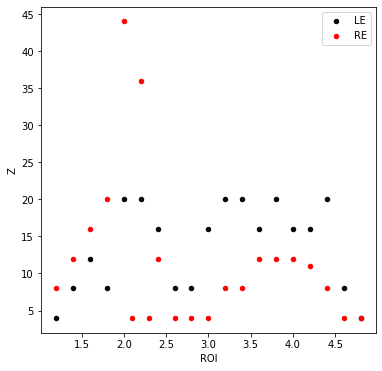

In [65]:
# Get the number of samples by ROI for each eye
le_data = in_data[in_data['Eye'] == 'LE']
re_data = in_data[in_data['Eye'] == 'RE']

le_count = le_data.groupby('ROI',as_index=False).count()
re_count = re_data.groupby('ROI',as_index=False).count()

# Plot against each other
this_fig, this_ax = plt.subplots(1,1,figsize=(6,6))
le_count.plot.scatter(x='ROI',y='Z',color='black',label='LE',ax=this_ax)
re_count.plot.scatter(x='ROI',y='Z',color='red',label='RE',ax=this_ax)

<AxesSubplot:xlabel='roi_bin', ylabel='Z'>

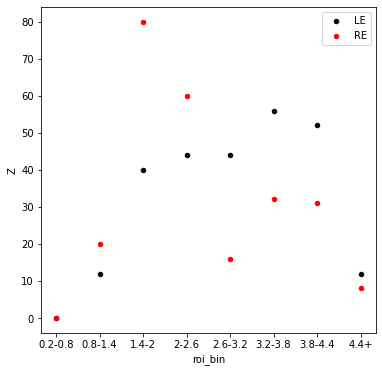

In [67]:
# Repeat, but perform the count by bin
le_count = le_data.groupby('roi_bin',as_index=False).count()
re_count = re_data.groupby('roi_bin',as_index=False).count()

# Plot against each other
this_fig, this_ax = plt.subplots(1,1,figsize=(6,6))
le_count.plot.scatter(x='roi_bin',y='Z',color='black',label='LE',ax=this_ax)
re_count.plot.scatter(x='roi_bin',y='Z',color='red',label='RE',ax=this_ax)

<AxesSubplot:xlabel='bin'>

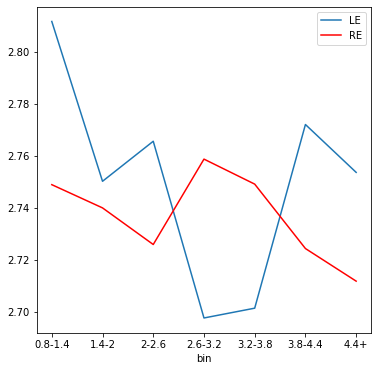

In [49]:
this_plt, ax = plt.subplots(figsize=(6,6))
le_data.groupby('bin').mean().plot.line(y='K',ax=ax,label='LE')
re_data.groupby('bin').mean().plot.line(y='K',ax=ax,color='red',label='RE')

<AxesSubplot:xlabel='bin'>

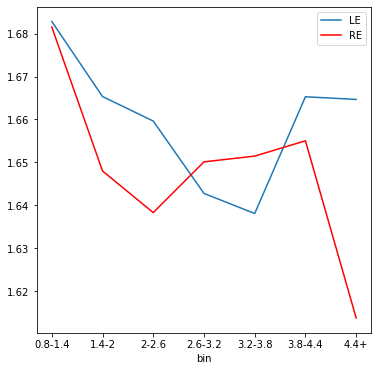

In [50]:
this_plt, ax = plt.subplots(figsize=(6,6))
le_data.groupby('bin').mean().plot.line(y='Z',ax=ax,label='LE')
re_data.groupby('bin').mean().plot.line(y='Z',ax=ax,color='red',label='RE')

In [86]:
# Start comparing the parameter values. First, Inf vs Sup
param_list = ['c','K','rho','alpha','Z'] # List of parameters for comparison
num_param = len(param_list)

# First, for all eyes, compare parameters in Inf vs Sup
inf_data = in_data[in_data['Region'] == 'INF']
sup_data = in_data[in_data['Region'] == 'SUP']

param_diff = np.zeros((num_param,3)) # column 1 is mean diff, column 2 is t-values, column 3 is p-values

for pp in range(num_param):
    this_param = param_list[pp]
    this_t, this_p = scipy.stats.ttest_ind(inf_data[this_param],sup_data[this_param])
    this_diff = inf_data[this_param].mean() - sup_data[this_param].mean()
    param_diff[pp,:] = [this_diff,this_t,this_p]

# Create a DataFrame from the t-test results
this_df = pd.DataFrame(param_diff,columns=['Diff (Inf-Sup)','t-values','p-values'],index=param_list)
print(this_df)

       Diff (Inf-Sup)  t-values  p-values
c          -30.722396 -3.065610  0.002289
K           -0.053240 -2.420115  0.015868
rho          0.006541  1.871970  0.061789
alpha        0.264322  0.803052  0.422322
Z           -0.020030 -2.820275  0.004987


In [91]:
# Repeat the Inf-Sup comparisons for LE and RE individually. Then compare LE-RE for Inf and Sup
le_param_diff = np.zeros((num_param,3))
re_param_diff = np.zeros((num_param,3))

le_inf_data = le_data[le_data['Region'] == 'INF']
le_sup_data = le_data[le_data['Region'] == 'SUP']
re_inf_data = re_data[re_data['Region'] == 'INF']
re_sup_data = re_data[re_data['Region'] == 'SUP']

for pp in range(num_param):
    this_param = param_list[pp]
    
    # t-test for left eye first
    this_t, this_p = scipy.stats.ttest_ind(le_inf_data[this_param],le_sup_data[this_param])
    this_diff = le_inf_data[this_param].mean() - le_sup_data[this_param].mean()
    le_param_diff[pp,:] = [this_diff, this_t, this_p]

    # t-test for right eye
    this_t, this_p = scipy.stats.ttest_ind(re_inf_data[this_param],re_sup_data[this_param])
    this_diff = re_inf_data[this_param].mean() - re_sup_data[this_param].mean()
    re_param_diff[pp,:] = [this_diff,this_t,this_p]

# Create DataFrames for the LE and RE summaries, this combine into one with a MultiIndex to summarize more concisely
le_df = pd.DataFrame(le_param_diff,columns=['Diff (Inf-Sup)','t-values','p-values'],index=param_list)
re_df = pd.DataFrame(re_param_diff,columns=['Diff (Inf-Sup)','t-values','p-values'],index=param_list)

le_df.columns = pd.MultiIndex.from_product([['LE'], le_df.columns])
re_df.columns = pd.MultiIndex.from_product([['RE'], re_df.columns])
full_df = pd.concat([le_df, re_df],axis=1)

pd.set_option('precision',4)
full_df


LE                                  RE                     
      Diff (Inf-Sup) t-values    p-values Diff (Inf-Sup) t-values    p-values
c           -26.1188  -1.7947  7.3868e-02       -35.3351  -2.4107  1.6661e-02
K            -0.0887  -2.8554  4.6478e-03        -0.0099  -0.2973  7.6650e-01
rho          -0.0127  -2.9030  4.0158e-03         0.0326   5.8913  1.2592e-08
alpha         0.0060   0.0152  9.8785e-01         0.8196   1.4225  1.5614e-01
Z            -0.0543  -5.1430  5.3524e-07         0.0282   3.0611  2.4510e-03

In [94]:
# This time, compare the Inf and Sup regions between LE and RE

inf_param_diff = np.zeros((num_param,3))
sup_param_diff = np.zeros((num_param,3))

for pp in range(num_param):
    this_param = param_list[pp]

    # Compare INF regions between LE and RE
    this_t, this_p = scipy.stats.ttest_ind(le_inf_data[this_param],re_inf_data[this_param])
    this_diff = le_inf_data[this_param].mean() - re_inf_data[this_param].mean()
    inf_param_diff[pp,:] = [this_diff,this_t,this_p]

    # Now compare SUP regions
    this_t, this_p = scipy.stats.ttest_ind(le_sup_data[this_param],re_sup_data[this_param])
    this_diff = le_sup_data[this_param].mean() - re_sup_data[this_param].mean()
    sup_param_diff[pp,:] = [this_diff,this_t,this_p]

# As before, create DataFrames and concatenate with MultiIndex to create a concise summary
inf_df = pd.DataFrame(inf_param_diff,columns=['Diff (LE-RE)','t-values','p-values'],index=param_list)
sup_df = pd.DataFrame(sup_param_diff,columns=['Diff (LE-RE)','t-values','p-values'],index=param_list)

inf_df.columns = pd.MultiIndex.from_product([['INF'], inf_df.columns])
sup_df.columns = pd.MultiIndex.from_product([['SUP'], sup_df.columns])

full_df = pd.concat([inf_df,sup_df],axis=1)

full_df

INF                            SUP                     
      Diff (LE-RE) t-values p-values Diff (LE-RE) t-values    p-values
c           6.1848   0.5234   0.6011      -3.0314  -0.1663  8.6812e-01
K          -0.0372  -1.4371   0.1517       0.0417   1.0446  2.9753e-01
rho        -0.0168  -3.9146   0.0001       0.0286   5.2743  3.6083e-07
alpha       0.0521   0.1238   0.9015       0.8656   1.6437  1.0190e-01
Z          -0.0273  -3.8590   0.0001       0.0552   3.8651  1.5235e-04

In [99]:
# Before starting to repeat some of the above on a per-layer basis, look for a difference in the parameters by layer generally
# Use ANOVA to determine if any of them differ
# Look at all eyes, then split into Inf/Sup and then further into LE/RE

fstats_all = np.zeros((num_param,2))

for pp, this_param in enumerate(param_list):
    this_fstat, this_p = scipy.stats.f_oneway(in_data[this_param][in_data['Layer'] == 1],
            in_data[this_param][in_data['Layer'] == 2],
            in_data[this_param][in_data['Layer'] == 3],
            in_data[this_param][in_data['Layer'] == 4])

    fstats_all[pp,:] = this_fstat, this_p

fstats_all_df = pd.DataFrame(fstats_all,columns=['f-stat','p-value'],index=param_list)
fstats_all_df

,f-stat,p-value
c,168.6849,1.1592e-75
K,152.8860,2.0333e-70
rho,77.7356,2.5089e-41
alpha,66.3122,3.8207e-36
Z,50.5151,1.4929e-28


In [103]:
# ANOVA by LE/RE
fstats_le = np.zeros((num_param,2))
fstats_re = np.zeros((num_param,2))

for pp, this_param in enumerate(param_list):
    this_data = le_data
    this_fstat, this_p = scipy.stats.f_oneway(this_data[this_param][this_data['Layer'] == 1],
            this_data[this_param][this_data['Layer'] == 2],
            this_data[this_param][this_data['Layer'] == 3],
            this_data[this_param][this_data['Layer'] == 4])

    fstats_le[pp,:] = [this_fstat, this_p]

    this_data = re_data
    this_fstat, this_p = scipy.stats.f_oneway(this_data[this_param][this_data['Layer'] == 1],
            this_data[this_param][this_data['Layer'] == 2],
            this_data[this_param][this_data['Layer'] == 3],
            this_data[this_param][this_data['Layer'] == 4])

    fstats_re[pp,:] = [this_fstat, this_p]

fstats_le_df = pd.DataFrame(fstats_le,columns=['f-stat','p-value'],index=param_list)
fstats_re_df = pd.DataFrame(fstats_re,columns=['f-stat','p-value'],index=param_list)

fstats_le_df.columns = pd.MultiIndex.from_product([['LE'], fstats_le_df.columns])
fstats_re_df.columns = pd.MultiIndex.from_product([['RE'], fstats_re_df.columns])

fstats_lere_df = pd.concat([fstats_le_df,fstats_re_df],axis=1)
fstats_lere_df

LE                   RE            
        f-stat     p-value   f-stat     p-value
c      96.6979  7.1771e-42  75.7207  1.2974e-34
K      82.1303  2.9904e-37  71.2484  4.3049e-33
rho    42.3652  2.9008e-22  37.1131  8.8155e-20
alpha  27.2294  2.5646e-15  39.6744  6.6497e-21
Z      28.3969  6.9517e-16  23.5323  2.0904e-13

In [106]:
# ANOVA by LE/RE split further by Inf/Sup

fstats_le_inf = np.zeros((num_param,2))
fstats_re_inf = np.zeros((num_param,2))
fstats_le_sup = np.zeros((num_param,2))
fstats_re_sup = np.zeros((num_param,2))

for pp, this_param in enumerate(param_list):
    this_data = le_inf_data
    this_fstat, this_p = scipy.stats.f_oneway(this_data[this_param][this_data['Layer'] == 1],
            this_data[this_param][this_data['Layer'] == 2],
            this_data[this_param][this_data['Layer'] == 3],
            this_data[this_param][this_data['Layer'] == 4])

    fstats_le_inf[pp,:] = [this_fstat, this_p]

    this_data = re_inf_data
    this_fstat, this_p = scipy.stats.f_oneway(this_data[this_param][this_data['Layer'] == 1],
            this_data[this_param][this_data['Layer'] == 2],
            this_data[this_param][this_data['Layer'] == 3],
            this_data[this_param][this_data['Layer'] == 4])

    fstats_re_inf[pp,:] = [this_fstat, this_p]

    this_data = le_sup_data
    this_fstat, this_p = scipy.stats.f_oneway(this_data[this_param][this_data['Layer'] == 1],
            this_data[this_param][this_data['Layer'] == 2],
            this_data[this_param][this_data['Layer'] == 3],
            this_data[this_param][this_data['Layer'] == 4])

    fstats_le_sup[pp,:] = [this_fstat, this_p]

    this_data = re_sup_data
    this_fstat, this_p = scipy.stats.f_oneway(this_data[this_param][this_data['Layer'] == 1],
            this_data[this_param][this_data['Layer'] == 2],
            this_data[this_param][this_data['Layer'] == 3],
            this_data[this_param][this_data['Layer'] == 4])

    fstats_re_sup[pp,:] = [this_fstat, this_p]

fstats_leinf_df = pd.DataFrame(fstats_le_inf,columns=['f-stat','p-value'],index=param_list)
fstats_reinf_df = pd.DataFrame(fstats_re_inf,columns=['f-stat','p-value'],index=param_list)
fstats_lesup_df = pd.DataFrame(fstats_le_sup,columns=['f-stat','p-value'],index=param_list)
fstats_resup_df = pd.DataFrame(fstats_re_sup,columns=['f-stat','p-value'],index=param_list)

fstats_leinf_df.columns = pd.MultiIndex.from_product([['LE INF'], fstats_leinf_df.columns])
fstats_reinf_df.columns = pd.MultiIndex.from_product([['RE INF'], fstats_reinf_df.columns])
fstats_lesup_df.columns = pd.MultiIndex.from_product([['LE SUP'], fstats_lesup_df.columns])
fstats_resup_df.columns = pd.MultiIndex.from_product([['RE SUP'], fstats_resup_df.columns])

fstats_lere_reg_df = pd.concat([fstats_leinf_df,fstats_lesup_df,fstats_reinf_df,fstats_resup_df],axis=1)
fstats_lere_reg_df

LE INF               LE SUP               RE INF               RE SUP  \
        f-stat     p-value   f-stat     p-value   f-stat     p-value   f-stat   
c      40.1846  2.2856e-18  64.2036  4.0279e-25  49.8633  1.7862e-23  40.8079   
K      34.8843  1.5161e-16  57.4292  2.4093e-23  46.4017  3.1030e-22  37.7373   
rho    31.3390  2.9422e-15  18.2153  7.4171e-10  28.9003  2.7481e-15  21.5976   
alpha  15.5326  1.1249e-08  13.2775  1.4252e-07  24.6589  2.1064e-13  24.6165   
Z      11.8938  6.3721e-07  24.0927  2.3671e-12  18.7510  1.2732e-10  10.2580   

                   
          p-value  
c      1.6799e-14  
K      7.8509e-14  
rho    1.3160e-09  
alpha  1.6553e-10  
Z      1.5145e-05

In [120]:
# The ANOVA for each case indicates that parameters in at least one of the layers has a different mean value when compared to the other layers for all parameters
# Now, compare the Inf/Sup values in each layer over all eyes, intra-eye (LE/RE), and inter-eye (LE-RE)

# First, over all eyes
num_layers = 4
layer_diff = {} # Going to make use of dictionary

for pp, this_param in enumerate(param_list):
    temp_diff_mat = np.zeros((num_layers,2))
    for ll in range(num_layers):
        this_inf_data = inf_data[inf_data['Layer'] == (ll+1)][this_param]
        this_sup_data = sup_data[sup_data['Layer'] == (ll+1)][this_param]
        this_t, this_p = scipy.stats.ttest_ind(this_inf_data,this_sup_data)
        temp_diff_mat[ll,:] = [this_t,this_p]

    layer_diff[this_param] = temp_diff_mat.copy()

# Create a DataFrame for each entry in the layer_diff dictionary, then concatenate all to concisely summarize
df_list = []
for pp, this_param in enumerate(param_list):
    this_df = pd.DataFrame(layer_diff[this_param],columns=['t-stat','p-value'],index=[1,2,3,4])
    this_df.columns = pd.MultiIndex.from_product([[this_param], this_df.columns])
    df_list.append(this_df)

full_df = pd.concat(df_list,axis=1)
full_df


c                   K             rho           alpha               Z  \
   t-stat     p-value  t-stat p-value  t-stat p-value  t-stat p-value  t-stat   
1  0.1772  8.5962e-01  0.6375  0.5250  0.6885  0.4924  1.5959  0.1130 -0.2328   
2 -4.2353  4.3874e-05 -3.5739  0.0005  0.6802  0.4977  0.5077  0.6125 -3.3824   
3 -2.2587  2.5634e-02 -2.2247  0.0279  0.7995  0.4255  0.1920  0.8481 -2.0968   
4 -2.3036  2.2910e-02 -1.2741  0.2050  2.4529  0.0156 -1.0978  0.2744  0.1882   

           
  p-value  
1  0.8163  
2  0.0010  
3  0.0380  
4  0.8510

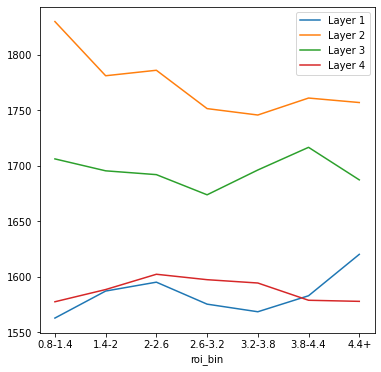

In [126]:
test_df = in_data.groupby(['roi_bin','Layer'],as_index=False).mean()
this_fig, this_ax = plt.subplots(1,1,figsize=(6,6))

for ll in range(num_layers):
    this_data = test_df[test_df['Layer'] == (ll+1)]
    this_data.plot.line(x='roi_bin',y='c',ax=this_ax,label=f'Layer {ll+1}')